# Pseudolikelihood Maximisation (PLM)

In [51]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from Utility.decorators import timer, exception_handler
from sympy import symbols, Sum, IndexedBase, log, cosh, diff, Piecewise, Ne, simplify
import sympy as sp

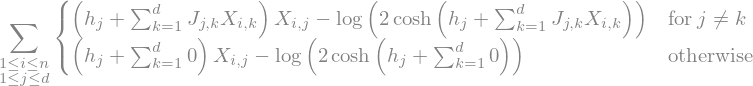

In [52]:
# Define the symbols for the dimensions and indices
n, d = symbols('n d', integer=True)
i, j, k = symbols('i j k', integer=True)

# Define the symbolic indexed bases for J, h, and X
J = IndexedBase('J', shape=(d, d))
h = IndexedBase('h', shape=(d,))
X = IndexedBase('X', shape=(n, d))

# Define S_ij excluding the k = j term
S_ij = Sum(Piecewise((J[j, k] * X[i, k], Ne(k, j)), (0, True)), (k, 1, d)) + h[j]

# Define the log-pseudolikelihood function LL
LL = Sum(X[i, j] * S_ij - log(2 * cosh(S_ij)), (i, 1, n), (j, 1, d))
LL

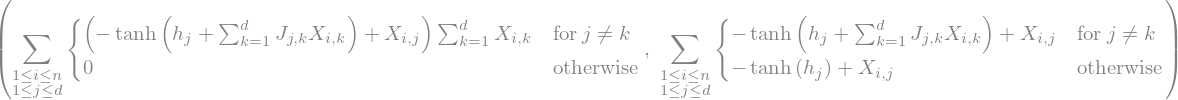

In [53]:
# Compute the symbolic gradients
grad_J_jk = diff(LL, J[j, k])
grad_h_j = diff(LL, h[j])

# Simplify the gradients
grad_J_jk_simplified = simplify(grad_J_jk)
grad_h_j_simplified = simplify(grad_h_j)

# Initialise pretty-printing
sp.init_printing(use_unicode=True)

# Display the expressions
grad_J_jk_simplified, grad_h_j_simplified

In [115]:
@timer
def log_pseudolikelihood_and_gradients_v1(J, h, X):
    """
    Initial code for calculating the log-pseudolikelihood and gradients closely follows my derived expression.
    """
    n, d = X.shape  # Number of samples and dimensions
    log_likelihood = 0
    grad_J = np.zeros_like(J)  # Initialise the gradient of J
    grad_h = np.zeros_like(h)  # Initialise the gradient of h

    for i in range(n):
        for j in range(d):
            # Compute S_ij without the contribution from jth term
            S_without_j = np.dot(J[j, :], X[i, :]) - J[j, j] * X[i, j]
            S_ij = S_without_j + h[j]
            
            # Update log-likelihood
            log_likelihood += X[i, j] * S_ij - np.log(2 * np.cosh(S_ij))
            
            # Update gradient of h
            grad_h[j] += -np.tanh(S_ij) + X[i, j]
            
            # Update gradient of J
            for k in range(d):
                if k != j:
                    grad_J[j, k] += (-np.tanh(S_ij) + X[i, j]) * X[i, k]
                    grad_J[k, j] = grad_J[j, k]  # Symmetric update

    # Return the negative likelihood and gradients for minimisation
    return -log_likelihood, -grad_J, -grad_h

@timer
def log_pseudolikelihood_and_gradients_v2(J, h, X):
    """
    Streamlined code for calculating the log-pseudolikelihood and gradients.
    """
    n, d = X.shape  # Number of samples and dimensions
    log_likelihood, grad_J, grad_h = 0, np.zeros_like(J), np.zeros_like(h)

    for i in range(n):
        for j in range(d):
            x_ij = X[i, j]
            S_ij = np.dot(J[j, :], X[i, :]) - J[j, j] * x_ij + h[j]
            log_likelihood += x_ij * S_ij - np.log(2 * np.cosh(S_ij))
            tanh_S_ij = np.tanh(S_ij)
            grad_h[j] += -tanh_S_ij + x_ij
            mask = np.ones(d, dtype=bool)
            mask[j] = False
            grad_J[j, mask] += (-tanh_S_ij + x_ij) * X[i, mask]
            grad_J[mask, j] = grad_J[j, mask]

    # Return the negative likelihood and gradients for minimisation
    return -log_likelihood, -grad_J, -grad_h

@timer
def log_pseudolikelihood_and_gradients_v3(J, h, X):
    """
    Vectorised code for super speedy performance.
    """
    d = X.shape[1]  # Number of dimensions
    log_likelihood, grad_J, grad_h = 0, np.zeros_like(J), np.zeros_like(h)

    # Vectorised version
    J_diag = np.diag(J)  # Get the diagonal of J
    S_ij = X @ J - X * J_diag + h  # Compute S_ij vectorized, broadcasting h
    log_likelihood = (X * S_ij).sum() - np.sum(np.log(2 * np.cosh(S_ij)))

    tanh_S_ij = np.tanh(S_ij)
    grad_h = np.sum(X - tanh_S_ij, axis=0)

    # Compute the gradient for J, excluding the diagonal
    # Create a mask to zero out diagonal contributions in the grad_J calculation
    mask = np.ones_like(J) - np.eye(d)
    grad_J = ((X - tanh_S_ij).T @ X) * mask
    grad_J = (grad_J + grad_J.T)

    # Return the negative likelihood and gradients for minimisation
    return -log_likelihood, -grad_J, -grad_h

# Define test inputs
X = pd.read_csv('Results/data_matrix.csv').drop(columns=["Date"]).to_numpy()
n, d = X.shape

# Initialise J as a symmetric matrix with zeros on the diagonal
# Elements are drawn from a uniform distribution over [-1, 1]
J_upper = np.triu(np.random.uniform(-1, 1, size=(d, d)), 1)  # Upper triangular part with 1 offset to exclude diagonal
J = J_upper + J_upper.T  # Symmetric matrix with zeros on the diagonal

# Initialise h as a one-dimensional array (vector) of size d
# Elements are drawn from a uniform distribution over [-1, 1]
h = np.random.uniform(-1, 1, size=d)

def compare_pseudolikelihood_functions(J, h, X):
    # Function names in a dictionary for iteration
    functions = {
        'v1': log_pseudolikelihood_and_gradients_v1,
        'v2': log_pseudolikelihood_and_gradients_v2,
        'v3': log_pseudolikelihood_and_gradients_v3
    }

    # Run each function and store results
    results = {name: func(J, h, X) for name, func in functions.items()}

    # Print results for each function
    for name, result in results.items():
        print(f"\nFunction {name} Results:")
        print("-log_likelihood:", result[0])
        print("-grad_J:\n", result[1][:3, :3])  # Print a 3x3 submatrix
        print(f"-grad_h:{result[2][:3]}")  # Print first 3 elements

    # Define specific pairs to compare
    comparison_pairs = [('v1', 'v2'), ('v1', 'v3')]

    # Compare results between each specified pair of functions
    for name1, name2 in comparison_pairs:
        result1, result2 = results[name1], results[name2]
        ll_same = np.allclose(result1[0], result2[0])
        grad_J_same = np.allclose(result1[1], result2[1])
        grad_h_same = np.allclose(result1[2], result2[2])
        print(f"{name1} vs {name2}: "
              f"LL: {'Same' if ll_same else 'Different'}, "
              f"Grad_J: {'Same' if grad_J_same else 'Different'}, "
              f"Grad_h: {'Same' if grad_h_same else 'Different'}")

compare_pseudolikelihood_functions(J, h, X)


'log_pseudolikelihood_and_gradients_v1' execution time: 3.059227 seconds
'log_pseudolikelihood_and_gradients_v2' execution time: 0.978447 seconds
'log_pseudolikelihood_and_gradients_v3' execution time: 0.019896 seconds

Function v1 Results:
-log_likelihood: 285997.2406212462
-grad_J:
 [[   -0.         -4491.73792137 -3683.98198155]
 [-4491.73792137    -0.         -5371.74663755]
 [-3683.98198155 -5371.74663755    -0.        ]]
-grad_h:[ -264.13346573 -1187.82592256  -681.62330315]

Function v2 Results:
-log_likelihood: 285997.2406212462
-grad_J:
 [[   -0.         -4491.73792137 -3683.98198155]
 [-4491.73792137    -0.         -5371.74663755]
 [-3683.98198155 -5371.74663755    -0.        ]]
-grad_h:[ -264.13346573 -1187.82592256  -681.62330315]

Function v3 Results:
-log_likelihood: 285997.24062124675
-grad_J:
 [[   -0.         -4491.73792137 -3683.98198155]
 [-4491.73792137    -0.         -5371.74663755]
 [-3683.98198155 -5371.74663755    -0.        ]]
-grad_h:[ -264.13346573 -1187.8259

# Optimisation

In [109]:
from Utility.IsingOptimiser import IsingOptimiser

ising_optimiser = IsingOptimiser('Results/data_matrix.csv')
J_optimised, h_optimised = ising_optimiser.optimise_all_subsets()
ising_optimiser.save_results(J_optimised, h_optimised, J_file_path='Results/J_matrix.csv', h_file_path='Results/h_vector.csv')

subset_1: Currencies 0 to 6
subset_2: Currencies 7 to 13
subset_3: Currencies 14 to 19
subset_4: Currencies 20 to 25
Optimising initial subsets...

Optimised J matrix for subset 1: 
[[ 0.          0.1450289   0.18477275  0.00910428  0.53205661  0.29969155
   0.01876158]
 [ 0.1450289   0.          0.28550715  0.03037822  0.13953035  0.09200766
   0.54941007]
 [ 0.18477275  0.28550715  0.          0.06259618  0.08157261  0.14886874
   0.12515521]
 [ 0.00910428  0.03037822  0.06259618  0.          0.06468166 -0.08112428
   0.29071406]
 [ 0.53205661  0.13953035  0.08157261  0.06468166  0.          0.17299995
   0.04301884]
 [ 0.29969155  0.09200766  0.14886874 -0.08112428  0.17299995  0.
   0.04405733]
 [ 0.01876158  0.54941007  0.12515521  0.29071406  0.04301884  0.04405733
   0.        ]]
Optimised h vector for subset 1: 
[ 0.04174791  0.01212477 -0.02852027 -0.03547642  0.01776742 -0.01662718
 -0.00815951]
Optimisation successful for subset 1: True
'wrapper' execution time: 0.019643 sec

# Boltzmann Machine

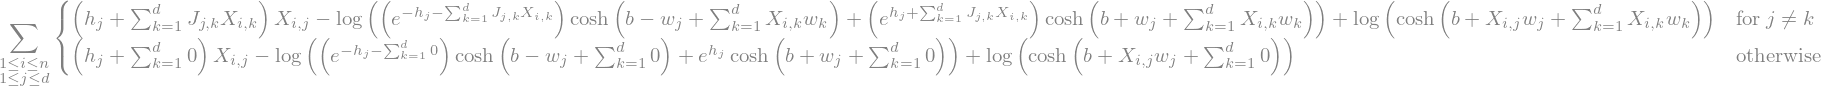

In [56]:
from sympy import symbols, Sum, IndexedBase, log, cosh, exp, diff, Piecewise, Ne, simplify
import sympy as sp

# Define the symbols for the dimensions and indices
n, d = symbols('n d', integer=True)
i, j, k = symbols('i j k', integer=True)
b = symbols('b', real=True)

# Define the symbolic indexed bases for J, h, w, and X
J = IndexedBase('J', shape=(d, d))
h = IndexedBase('h', shape=(d,))
w = IndexedBase('w', shape=(d,))
X = IndexedBase('X', shape=(n, d))

# Define S_ij and S_ik excluding the k = j term
S_ij = Sum(Piecewise((J[j, k] * X[i, k], Ne(k, j)), (0, True)), (k, 1, d)) + h[j]
S_ik = Sum(Piecewise((w[k] * X[i, k], Ne(k, j)), (0, True)), (k, 1, d)) + b

# Define the log-pseudolikelihood function LL
LL = Sum(X[i, j] * S_ij + log(cosh(w[j] * X[i, j] + S_ik)) - log(
    exp(S_ij) * cosh(w[j] + S_ik) + exp(-S_ij) * cosh(-w[j] + S_ik)), (i, 1, n), (j, 1, d))
LL

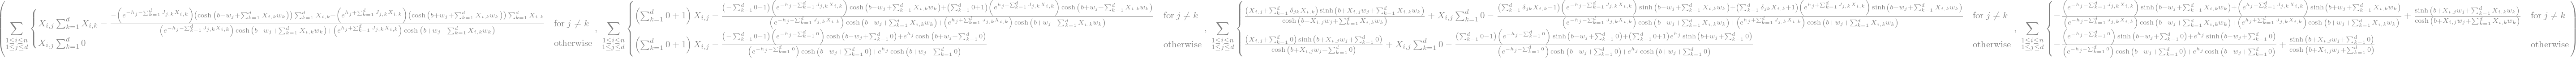

In [57]:
# Compute the symbolic gradients
grad_J_jk = diff(LL, J[j, k])
grad_h_j = diff(LL, h[j])
grad_w_j = diff(LL, w[j])
grad_b = diff(LL, b)

# Simplify the gradients
grad_J_jk_simplified = simplify(grad_J_jk)
grad_h_j_simplified = simplify(grad_h_j)
grad_w_j_simplified = simplify(grad_w_j)
grad_b_simplified = simplify(grad_b)

# Initialise pretty-printing
sp.init_printing(use_unicode=True)

# Display the expressions
grad_J_jk, grad_h_j, grad_w_j, grad_b

In [113]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from Utility.decorators import timer, exception_handler, debug

@timer
def log_pseudolikelihood_v1(J, h, w, b, X):
    n, d = X.shape  # Number of samples and dimensions
    log_likelihood = 0
    grad_J = np.zeros_like(J)  # Initialise the gradient of J
    grad_h = np.zeros_like(h)  # Initialise the gradient of h
    grad_w = np.zeros_like(w)  # Initialise the gradient of w
    grad_b = 0                 # Initialise the gradient of b as a scalar

    for i in range(n):
        for j in range(d):
            # Compute S_ij without the contribution from the j-th term
            S_without_j = np.dot(J[j, :], X[i, :]) - J[j, j] * X[i, j]
            S_ij = S_without_j + h[j]
            
            # Compute S_ik
            S_ik = np.dot(w, X[i, :]) + b - w[j] * X[i, j]

            # components used in the log likelihood and gradients
            x_ij = X[i, j]
            exp_pos_Sij = np.exp(S_ij)
            exp_neg_Sij = np.exp(-S_ij)
            cosh_pos = np.cosh(w[j] + S_ik)
            cosh_neg = np.cosh(w[j] - S_ik)
            sinh_pos = np.sinh(w[j] + S_ik)
            sinh_neg = np.sinh(w[j] - S_ik)
            denominator = exp_pos_Sij * cosh_pos + exp_neg_Sij * cosh_neg

            # Update log-likelihood for the new LL expression
            log_likelihood += (
                x_ij * S_ij +
                np.log(np.cosh(w[j] * X[i, j] + S_ik)) -
                np.log(denominator)
            )

            # grad_h update
            numerator_h = -exp_neg_Sij * cosh_neg + exp_pos_Sij * cosh_pos
            grad_h[j] += x_ij - (numerator_h / denominator)

            # grad_w update
            numerator_w = -exp_neg_Sij * sinh_neg + exp_pos_Sij * sinh_pos
            grad_w[j] += x_ij * (np.tanh(w[j] * X[i, j] + S_ik) - (numerator_w / denominator))

            # grad_b update
            numerator_b = exp_neg_Sij * sinh_neg + exp_pos_Sij * sinh_pos
            grad_b += np.tanh(w[j] * X[i, j] + S_ik) - (numerator_b / denominator)

            # grad_J update
            numerator_J = -exp_neg_Sij * cosh_neg + exp_pos_Sij * cosh_pos
            for k in range(d):
                if k != j:
                    grad_J[j, k] += (x_ij - (numerator_J / denominator)) * X[i, k]
                    grad_J[k, j] = grad_J[j, k]  # Symmetric update

    # Return the negative likelihood and gradients for minimisation
    return -log_likelihood, -grad_J, -grad_h, -grad_w, -grad_b

@timer
def log_pseudolikelihood_v2(J, h, w, b, X):
    n, d = X.shape  # Number of samples and dimensions
    log_likelihood = 0
    grad_J, grad_h, grad_w, grad_b = np.zeros_like(J), np.zeros_like(h), np.zeros_like(w), 0

    for i in range(n):
        full_S_ik = np.dot(w, X[i, :]) + b
        for j in range(d):
            x_ij = X[i, j]
            S_ij = np.dot(J[j, :], X[i, :]) - J[j, j] * X[i, j] + h[j]
            S_ik = np.dot(w, X[i, :]) - w[j] * X[i, j] + b

            exp_pos_Sij = np.exp(S_ij)
            exp_neg_Sij = np.exp(-S_ij)
            cosh_pos = np.cosh(w[j] + S_ik)
            cosh_neg = np.cosh(w[j] - S_ik)
            sinh_pos = np.sinh(w[j] + S_ik)
            sinh_neg = np.sinh(w[j] - S_ik)
            denominator = exp_pos_Sij * cosh_pos + exp_neg_Sij * cosh_neg

            # Update log-likelihood for the new LL expression
            log_likelihood += (
                x_ij * S_ij +
                np.log(np.cosh(full_S_ik)) -
                np.log(denominator)
            )

            # grad_h update
            numerator_h = -exp_neg_Sij * cosh_neg + exp_pos_Sij * cosh_pos
            grad_h[j] += x_ij - (numerator_h / denominator)

            # grad_w update
            numerator_w = -exp_neg_Sij * sinh_neg + exp_pos_Sij * sinh_pos
            grad_w[j] += x_ij * (np.tanh(full_S_ik) - (numerator_w / denominator))

            # grad_b update
            numerator_b = exp_neg_Sij * sinh_neg + exp_pos_Sij * sinh_pos
            grad_b += np.tanh(full_S_ik) - (numerator_b / denominator)

            # grad_J update
            mask = np.ones(d, dtype=bool)
            mask[j] = False
            numerator_J = -exp_neg_Sij * cosh_neg + exp_pos_Sij * cosh_pos
            grad_J[j, mask] += (x_ij - (numerator_J / denominator)) * X[i, mask]
            grad_J[mask, j] = grad_J[j, mask]  # Symmetric update

    # Return the negative likelihood and gradients for minimisation
    return -log_likelihood, -grad_J, -grad_h, -grad_w, -grad_b

@timer
def log_pseudolikelihood_v3(J, h, w, b, X):
    d = X.shape[1]  # Number of dimensions

    S_ij = X @ J - X * np.diag(J)+ h  # Broadcasting h and subtracting j=j terms
    full_S_ik = X @ w + b # for all samples
    S_ik = X @ w.reshape(-1, 1) + b - X * w  # Broadcasting w

    # Calculate the components used in the log likelihood and gradients
    exp_pos_Sij = np.exp(S_ij)
    exp_neg_Sij = 1 / exp_pos_Sij
    cosh_pos = np.cosh(w + S_ik)
    cosh_neg = np.cosh(w - S_ik)
    sinh_pos = np.sinh(w + S_ik)
    sinh_neg = np.sinh(w - S_ik)
    denominator = exp_pos_Sij * cosh_pos + exp_neg_Sij * cosh_neg

    x_times_Sij = X * S_ij  # Sum over dimensions for each sample
    log_numerator= np.log(np.cosh(full_S_ik.reshape(-1, 1)))  # Reshape to 2D
    log_denominator = np.log(denominator)  # Sum over dimensions for each sample

    # Combine the terms and sum over all samples to get the scalar log-likelihood
    log_likelihood = (x_times_Sij + log_numerator - log_denominator).sum()

    # Gradients
    numerator_h = -exp_neg_Sij * cosh_neg + exp_pos_Sij * cosh_pos
    grad_h = (X - numerator_h / denominator).sum(axis=0)

    numerator_w = -exp_neg_Sij * sinh_neg + exp_pos_Sij * sinh_pos
    grad_w = (X.T * (np.tanh(full_S_ik.T) - (numerator_w / denominator).T)).sum(axis=1)

    numerator_b = exp_neg_Sij * sinh_neg + exp_pos_Sij * sinh_pos
    grad_b = (np.tanh(full_S_ik.reshape(-1, 1)) - (numerator_b / denominator)).sum(axis=0).sum()

    # Gradient for J, excluding the diagonal
    mask = np.ones_like(J) - np.eye(d)
    numerator_J = -exp_neg_Sij * cosh_neg + exp_pos_Sij * cosh_pos
    grad_J = ((X - numerator_J / denominator).T @ X) * mask
    grad_J = grad_J + grad_J.T  # Symmetrise

    # Return the negative likelihood and gradients for minimisation
    return -log_likelihood, -grad_J, -grad_h, -grad_w, -grad_b

# Read data
X = pd.read_csv('Results/data_matrix.csv').drop(columns=["Date"]).to_numpy()
# X = np.random.choice([-1, 1], size=(5, 5))
n, d = X.shape

# Initialize J, h, w, and b
J_upper = np.triu(np.random.uniform(-1, 1, size=(d, d)), 1)
J = J_upper + J_upper.T
h = np.random.uniform(-1, 1, size=d)
w = np.random.uniform(-1, 1, size=d)
b = np.random.uniform(-1, 1)

# Function to compare pseudolikelihood functions
def compare_pseudolikelihood_functions(J, h, w, b, X):
    functions = {
        'v1': log_pseudolikelihood_v1,
        'v2': log_pseudolikelihood_v2,
        'v3': log_pseudolikelihood_v3
    }

    results = {name: func(J, h, w, b, X) for name, func in functions.items()}

    for name, result in results.items():
        if result[0] is not None:  # Check if result is not None
            print(f"\nFunction {name} Results:")
            print("-log_likelihood:", result[0])
            print("-grad_J:\n", result[1][:3, :3])
            print(f"-grad_h:{result[2][:3]}")
            print(f"-grad_w:{result[3][:3]}")
            print(f"-grad_b:{result[4]}")

    comparison_pairs = [('v1', 'v2'), ('v1', 'v3')]

    # Compare results between each specified pair of functions
    for name1, name2 in comparison_pairs:
        result1, result2 = results[name1], results[name2]
        ll_same = np.allclose(result1[0], result2[0])
        grad_J_same = np.allclose(result1[1], result2[1])
        grad_h_same = np.allclose(result1[2], result2[2])
        grad_w_same = np.allclose(result1[3], result2[3])
        grad_b_same = np.allclose(result1[4], result2[4])
        print(f"{name1} vs {name2}: "
              f"LL: {'Same' if ll_same else 'Different'}, "
              f"Grad_J: {'Same' if grad_J_same else 'Different'}, "
              f"Grad_h: {'Same' if grad_h_same else 'Different'}, "
              f"Grad_w: {'Same' if grad_w_same else 'Different'}, "
              f"Grad_b: {'Same' if grad_b_same else 'Different'}")

compare_pseudolikelihood_functions(J, h, w, b, X)


'log_pseudolikelihood_v1' execution time: 2.299447 seconds
'log_pseudolikelihood_v2' execution time: 1.671707 seconds
'log_pseudolikelihood_v3' execution time: 0.040485 seconds

Function v1 Results:
-log_likelihood: 368187.6617991789
-grad_J:
 [[   -0.         -3538.28891401 -1645.01903998]
 [-3538.28891401    -0.         -5038.13777741]
 [-1645.01903998 -5038.13777741    -0.        ]]
-grad_h:[-1389.43831319   323.6702813    932.56935419]
-grad_w:[ -698.72896264 -1503.16696037   289.33341652]
-grad_b:3272.8583129628078

Function v2 Results:
-log_likelihood: 368187.6617991789
-grad_J:
 [[   -0.         -3538.28891401 -1645.01903998]
 [-3538.28891401    -0.         -5038.13777741]
 [-1645.01903998 -5038.13777741    -0.        ]]
-grad_h:[-1389.43831319   323.6702813    932.56935419]
-grad_w:[ -698.72896264 -1503.16696037   289.33341652]
-grad_b:3272.8583129628078

Function v3 Results:
-log_likelihood: 368187.6617991828
-grad_J:
 [[   -0.         -3538.28891401 -1645.01903998]
 [-3538.28

In [111]:
class BoltzmannMachine:
    def __init__(self, data_matrix_df, J_matrix_df, h_vector_df):
        self.data_matrix_df = data_matrix_df
        self.symbols = data_matrix_df.columns.tolist()
        self.data_matrix = data_matrix_df.drop(columns=["Date"]).to_numpy()
        self.J = J_matrix_df.values
        self.h = h_vector_df[1].values
        self.w = np.random.uniform(-1, 1, size=(self.data_matrix.shape[1]))
        self.b = np.random.uniform(-1, 1)
        self.Z = np.random.choice([-1, 1], size=(self.data_matrix.shape[0],))
        # print(f"J.shape: {self.J.shape}, h: {self.h}, w: {self.w}, b: {self.b}, X.shape: {self.data_matrix.shape}, Z.shape: {self.Z.shape}")
    
    @staticmethod
    def _log_pseudolikelihood(J, h, w, b, X):
        n, d = X.shape  # Number of samples and dimensions

        S_ij = X @ J - X * np.diag(J)+ h  # Broadcasting h and subtracting j=j terms
        full_S_ik = X @ w + b # for all samples
        S_ik = X @ w.reshape(-1, 1) + b - X * w  # Broadcasting w

        # Calculate the components used in the log likelihood and gradients
        exp_pos_Sij = np.exp(S_ij)
        exp_neg_Sij = 1 / exp_pos_Sij
        cosh_pos = np.cosh(w + S_ik)
        cosh_neg = np.cosh(w - S_ik)
        sinh_pos = np.sinh(w + S_ik)
        sinh_neg = np.sinh(w - S_ik)
        denominator = exp_pos_Sij * cosh_pos + exp_neg_Sij * cosh_neg

        x_times_Sij = X * S_ij  # Sum over dimensions for each sample
        log_numerator= np.log(np.cosh(full_S_ik.reshape(-1, 1)))  # Reshape to 2D
        log_denominator = np.log(denominator)  # Sum over dimensions for each sample

        # Combine the terms and sum over all samples to get the scalar log-likelihood
        log_likelihood = (x_times_Sij + log_numerator - log_denominator).sum()

        # Gradients
        numerator_h = -exp_neg_Sij * cosh_neg + exp_pos_Sij * cosh_pos
        grad_h = (X - numerator_h / denominator).sum(axis=0)

        numerator_w = -exp_neg_Sij * sinh_neg + exp_pos_Sij * sinh_pos
        grad_w = (X.T * (np.tanh(full_S_ik.T) - (numerator_w / denominator).T)).sum(axis=1)

        numerator_b = exp_neg_Sij * sinh_neg + exp_pos_Sij * sinh_pos
        grad_b = (np.tanh(full_S_ik.reshape(-1, 1)) - (numerator_b / denominator)).sum(axis=0).sum()

        # Gradient for J, excluding the diagonal
        mask = np.ones_like(J) - np.eye(d)
        numerator_J = -exp_neg_Sij * cosh_neg + exp_pos_Sij * cosh_pos
        grad_J = ((X - numerator_J / denominator).T @ X) * mask
        grad_J = grad_J + grad_J.T  # Symmetrise

        print(f"-log_likelihood: {-log_likelihood}")
        # Return the negative likelihood and gradients for minimisation
        return -log_likelihood/n, -grad_J/n, -grad_h/n, -grad_w/n, -grad_b/n

    @staticmethod
    def _reconstruct_parameters(flattened_array, N):
        """
        Helper function to reconstruct the symmetric J matrix, h vector, w vector, and scalar b from a flattened array.
        """
        num_J_elements = N * (N - 1) // 2
        J_upper_tri = flattened_array[:num_J_elements]
        h = flattened_array[num_J_elements:num_J_elements + N]
        w = flattened_array[num_J_elements + N:-1]
        b = flattened_array[-1]  # Last element is scalar b

        # Construct the symmetric J matrix from the upper triangular part
        J = np.zeros((N, N))
        J[np.triu_indices(N, k=1)] = J_upper_tri
        J += J.T  # Symmetrise the J matrix

        # Check if diagonal filling is necessary
        if np.any(J.diagonal() != 0):
            print("hello world!")
            np.fill_diagonal(J, 0)

        return J, h, w, b

    @staticmethod
    def _predict_Z(data_matrix, w, b):
        """
        Predict Z using the data_matrix and optimised parameters
        """
        Z_predicted = np.zeros(data_matrix.shape[0])
        for i in range(data_matrix.shape[0]):
            # Calculate the effective field for each sample
            h_eff = np.dot(w, data_matrix[i, :]) + b
            # Predict the state of Z based on the sign of the effective field
            Z_predicted[i] = 1 if h_eff > 0 else -1
        return Z_predicted

    def _optimise_model(self, data):
        """
        Define the optimisation function with the modified likelihood function
        """
        N = data.shape[1]  # Number of variables (currencies)

        def objective_function(x):
            J, h, w, b = self._reconstruct_parameters(x, N)  # Ensure this matches the structure of x0
            likelihood, grad_J, grad_h, grad_w, grad_b = self._log_pseudolikelihood(J, h, w, b, data)
            
            # Flatten the gradient of J (upper triangle only, since it's symmetric)
            grad_J_flat = grad_J[np.triu_indices(N, k=1)]
            
            # Concatenate all gradients into a one-dimensional array
            grad = np.concatenate([grad_J_flat, grad_h, grad_w, np.array([grad_b])])
            return likelihood, grad

        # Flatten the parameters for optimisation
        J_flat = self.J[np.triu_indices(N, k=1)]
        x0 = np.concatenate([J_flat, self.h, self.w, np.array([self.b])])

        # Execute the optimisation
        res = minimize(objective_function, x0, method='L-BFGS-B', jac=True)

        # Reconstruct the optimised parameters
        self.J, self.h, self.w, self.b = self._reconstruct_parameters(res.x, N)
        return res.success

    def train(self, max_iterations=10, convergence_threshold=0.01):
        """
        Optimisation and Prediction Process

        1. 'convergence_threshold' is a parameter representing the fraction of elements in Z that must change for the algorithm to be considered not yet converged.
        2. 'change_threshold' translates this fraction into an actual number of elements.
        3. After each iteration, the method checks how many elements in Z have changed ('num_changed') compared to the previous iteration.
        4. If 'num_changed' is less than or equal to 'change_threshold', the method considers the algorithm to have converged and stops the iterations.
        """
        previous_Z = np.copy(self.Z)
        num_elements = len(self.Z)
        change_threshold = int(convergence_threshold * num_elements)

        for iteration in range(max_iterations):
            print(f"Iteration: {iteration + 1}")

            success = self._optimise_model(self.data_matrix)
            if not success:
                print(f"Optimisation did not converge in iteration {iteration}")
                break

            self.Z = self._predict_Z(self.data_matrix, self.w, self.b)

            # Check for convergence
            num_changed = np.sum(self.Z != previous_Z)
            print(f"Number of Z elements changed in iteration {iteration + 1}: {num_changed}")
            
            if num_changed <= change_threshold:
                print(f"Convergence reached in iteration {iteration}")
                break

            previous_Z = np.copy(self.Z)

    def save_results(self, J_matrix_path, h_vector_path, 
                    J_matrix_extended_path, h_vector_extended_path, data_matrix_extended_path):
        """
        Save optimised and extended results of the Boltzmann machine.
        """
        # Save optimised results (J matrix and h vector only)
        self._save_optimised_results(J_matrix_path, h_vector_path)

        # Save extended results with Z (Extended J matrix, h vector, and data matrix)
        self._save_extended_results(J_matrix_extended_path, h_vector_extended_path, data_matrix_extended_path)

    def _save_optimised_results(self, J_matrix_path, h_vector_path):
        """
        Save the optimised J matrix and h vector.
        """
        pd.DataFrame(self.J, columns=self.symbols, index=self.symbols).to_csv(J_matrix_path, index=False)
        print(f"The optimised J matrix has been saved to '{J_matrix_path}'.")

        h_df = pd.DataFrame({'h': self.h}, index=self.symbols)
        h_df.to_csv(h_vector_path, index=True, header=False)
        print(f"The optimised h vector has been saved to '{h_vector_path}'.")

    def _save_extended_results(self, J_matrix_extended_path, h_vector_extended_path, data_matrix_extended_path):
        """
        Save the extended J matrix, h vector, and data matrix including Z.
        """
        # Extended J matrix
        J_extended = np.zeros((27, 27))
        J_extended[0, 1:] = J_extended[1:, 0] = self.w
        J_extended[1:, 1:] = self.J
        symbols_extended = ['USD'] + self.symbols
        pd.DataFrame(J_extended, columns=symbols_extended, index=symbols_extended).to_csv(J_matrix_extended_path, index=False)
        print(f"The extended optimised J matrix has been saved to '{J_matrix_extended_path}'.")

        # Extended h vector
        h_values_with_b = [self.b] + list(self.h)
        h_df_extended = pd.DataFrame({'h': h_values_with_b}, index=['USD'] + self.symbols)
        h_df_extended.to_csv(h_vector_extended_path, index=True, header=False)
        print(f"The extended optimised h vector has been saved to '{h_vector_extended_path}'.")

        # Extended data matrix with Z
        data_matrix_df_extended = self.data_matrix_df.copy()
        data_matrix_df_extended.insert(1, 'USD', self.Z)
        data_matrix_df_extended.to_csv(data_matrix_extended_path, index=False)
        print(f"Extended data matrix saved to '{data_matrix_extended_path}'.")

# Load data and Initialise Parameters
data_matrix_df = pd.read_csv("Results/data_matrix.csv")
J_matrix_df = pd.read_csv("Results/J_matrix.csv")
h_vector_df = pd.read_csv("Results/h_vector.csv", header=None)

# Create and use BoltzmannMachine
bm = BoltzmannMachine(data_matrix_df, J_matrix_df, h_vector_df)
bm.train(max_iterations=15, convergence_threshold=0.001)

Iteration: 1
-log_likelihood: 69520.44554204983
-log_likelihood: 66960.35132793368
-log_likelihood: 81842.35667606554
-log_likelihood: 66506.4473727326
-log_likelihood: 67009.31840812085
-log_likelihood: 66535.55886256968
-log_likelihood: 66506.4473727326
-log_likelihood: 84303.23182292157
-log_likelihood: 70627.77307496424
-log_likelihood: 66882.27357116045
-log_likelihood: 66568.95507512428
-log_likelihood: 66518.89888975008
-log_likelihood: 66509.02503376469
-log_likelihood: 66506.98531498898
-log_likelihood: 66506.55982786519
-log_likelihood: 66506.47088943287
-log_likelihood: 66506.45229092581
-log_likelihood: 66506.44840132071
-log_likelihood: 66506.44758785164
-log_likelihood: 66506.44741772264
-log_likelihood: 66506.44738214184
-log_likelihood: 66506.44737470048
-log_likelihood: 66506.44737314415
-log_likelihood: 66506.44737281867
-log_likelihood: 66506.44737275061
-log_likelihood: 66506.44737273637
-log_likelihood: 66506.44737273341
Optimisation did not converge in iteration 0

In [ ]:
bm.save_results('Results/optimised_J_matrix.csv', 'Results/optimised_h_vector.csv',
                'Results/optimised_J_matrix_extended.csv', 'Results/optimised_h_vector_extended.csv', 'Results/data_matrix_extended.csv')

The optimised J matrix has been saved to 'Results/optimised_J_matrix.csv'.
The optimised h vector has been saved to 'Results/optimised_h_vector.csv'.
The extended optimised J matrix has been saved to 'Results/optimised_J_matrix_extended.csv'.
The extended optimised h vector has been saved to 'Results/optimised_h_vector_extended.csv'.
Extended data matrix saved to 'Results/data_matrix_extended.csv'.


# Trend Analysis

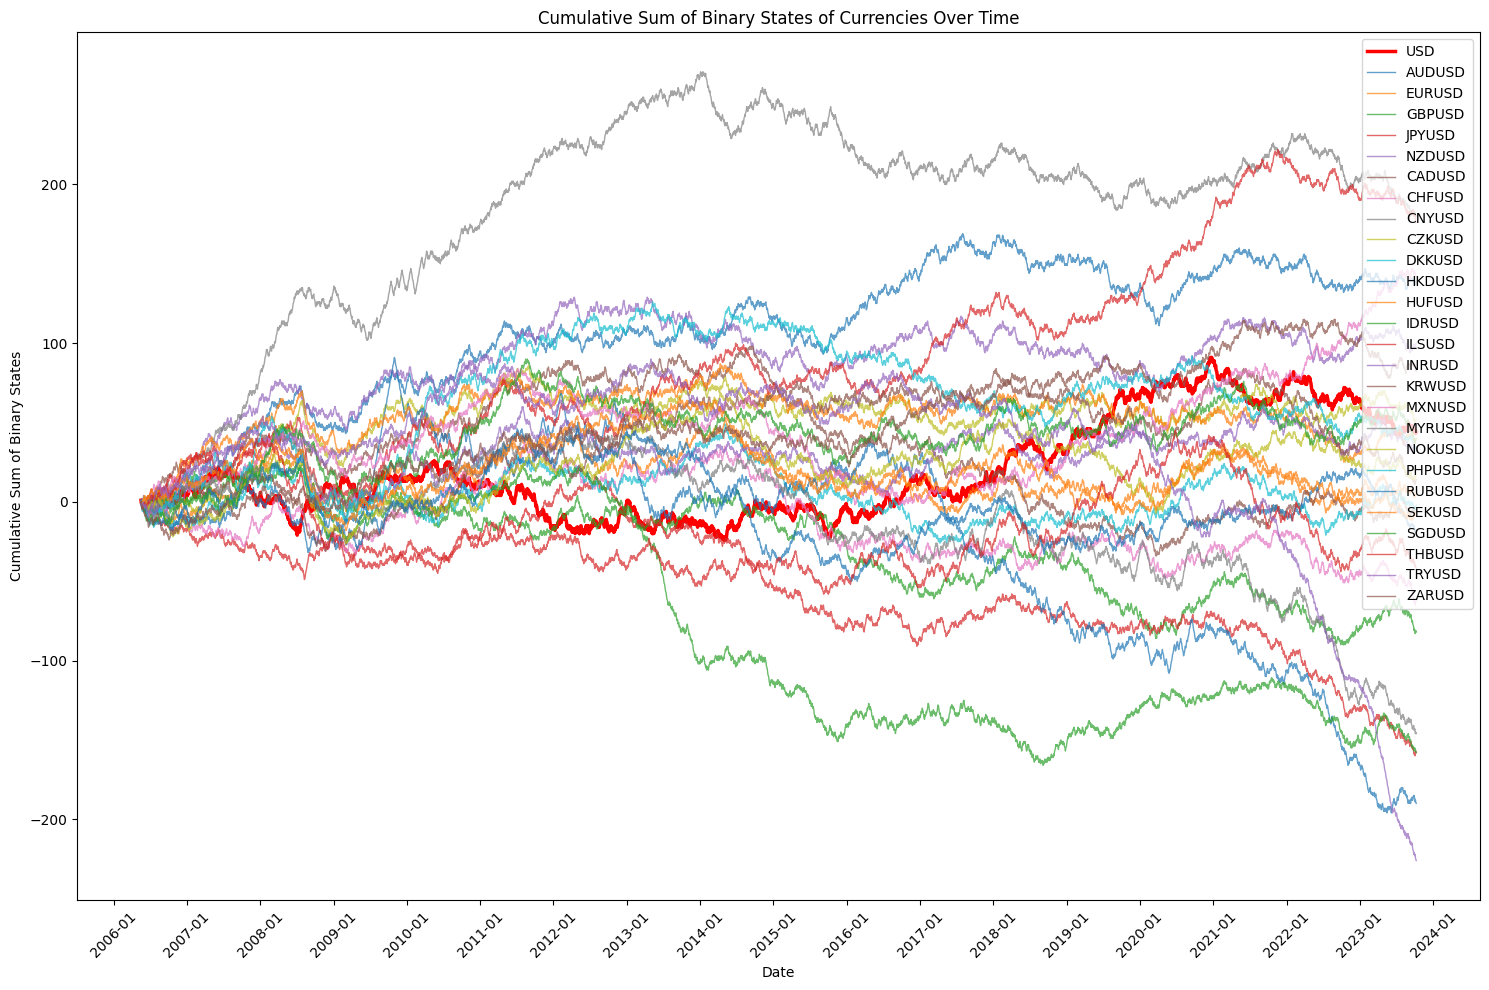

In [ ]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Define utility functions
def format_date_axis():
    """Formats the date axis with year and month."""
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.xticks(rotation=45)

def plot_cumulative_binary_states(data, cumsum_data, title, highlight_currency=None):
    """Plots the cumulative sum of binary states for given currencies."""
    plt.figure(figsize=(15, 10))
    for column in cumsum_data.columns:
        if column == highlight_currency:
            # Highlight the specified currency with a different style
            plt.plot(data['Date'], cumsum_data[column], label=column, linewidth=2.5, color='red')
        else:
            plt.plot(data['Date'], cumsum_data[column], label=column, linewidth=1, alpha=0.7)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Sum of Binary States')
    plt.title(title)
    format_date_axis()
    plt.legend()
    plt.tight_layout()
    plt.show()

# Read and process data
data_matrix_extended = pd.read_csv("Results/data_matrix_extended.csv")

# Convert the 'Date' column to datetime and sort the data
data_matrix_extended['Date'] = pd.to_datetime(data_matrix_extended['Date'])

# Cumulative sum of binary states
data_matrix_cumsum = data_matrix_extended.drop(columns=['Date']).cumsum()

# Plot with USD highlighted
plot_cumulative_binary_states(data_matrix_extended, data_matrix_cumsum, 
                            'Cumulative Sum of Binary States of Currencies Over Time', 
                            highlight_currency='USD')